Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [97]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [99]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Train/') 
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [100]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [103]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [105]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # Split 20% for validation
    subset="training",     # Use the training subset
    seed=123,              # Set random seed
    image_size=(img_height, img_width), # Resize images
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [106]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # Split 20% for validation
    subset="validation",   # Use the validation subset
    seed=123,              # Set random seed
    image_size=(img_height, img_width), # Resize images
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [107]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

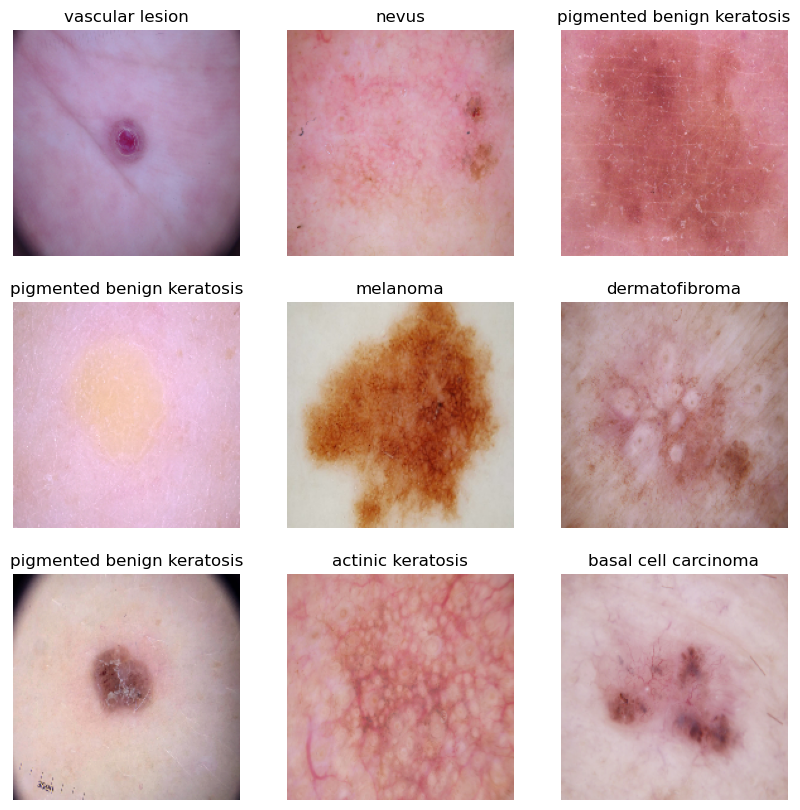

In [109]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [112]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [114]:
### Your code goes here
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Create the CNN model
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Normalize pixel values
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')  # Number of classes (9)
])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [116]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',  # Adam optimizer
              loss='sparse_categorical_crossentropy',  # Appropriate loss function for multi-class classification
              metrics=['accuracy'])

In [117]:
# View the summary of all layers
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [119]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 245ms/step - accuracy: 0.1823 - loss: 2.2709 - val_accuracy: 0.2819 - val_loss: 1.9682
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step - accuracy: 0.3983 - loss: 1.7463 - val_accuracy: 0.4609 - val_loss: 1.5720
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 233ms/step - accuracy: 0.4707 - loss: 1.5023 - val_accuracy: 0.4966 - val_loss: 1.5130
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 234ms/step - accuracy: 0.5042 - loss: 1.4464 - val_accuracy: 0.5011 - val_loss: 1.4383
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step - accuracy: 0.5345 - loss: 1.3242 - val_accuracy: 0.4922 - val_loss: 1.4273
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 232ms/step - accuracy: 0.5724 - loss: 1.2450 - val_accuracy: 0.4966 - val_loss: 1.4578
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 242ms/step - accuracy: 0.5782 - loss: 1.1952 - val_accuracy: 0.5078 - val_loss: 1.3385
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 232ms/step - accuracy: 0.6254 - loss: 1.0898 - val_accu

### Visualizing training results

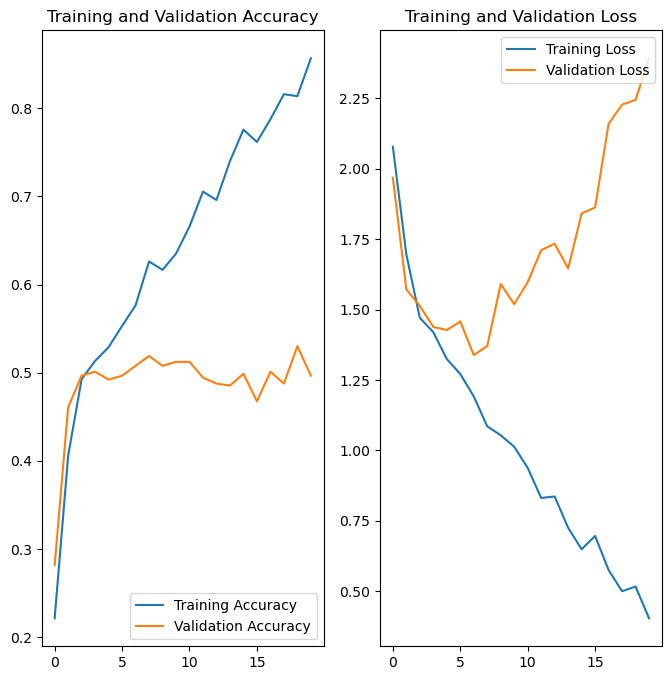

In [121]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings
The plots suggest overfitting, with a gap in accuracy and rising validation loss. Regularization may help improve generalization.

### Write your findings here

In [124]:
# Choose an appropriate data augumentation strategy.

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Define the data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

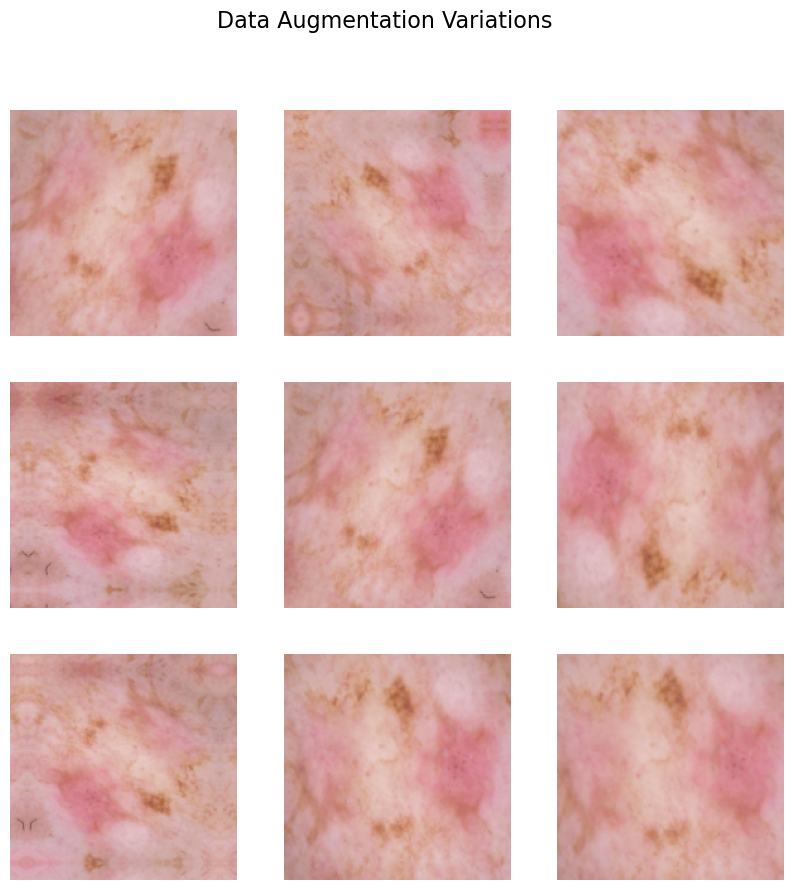

In [125]:
# Get one batch of images from the training dataset
for images, _ in train_ds.take(1):  
    sample_image = images[0]  # Select one image
    break

# Expand dimensions to make it compatible with augmentation layers
sample_image = tf.expand_dims(sample_image, axis=0)

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(sample_image, training=True)  # Apply augmentation
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

plt.suptitle("Data Augmentation Variations", fontsize=16)
plt.show()

### Todo:
### Create the model, compile and train the model


In [127]:
# Apply data augmentation before model training
model = Sequential([
    data_augmentation,  # Data augmentation layer
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Normalize pixel values
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Regularization to prevent overfitting
    layers.Dense(len(class_names), activation='softmax')  # Output layer
])



/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compiling the model

In [129]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [131]:
# Train with early stopping and learning rate reduction
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 252ms/step - accuracy: 0.1881 - loss: 2.4556 - val_accuracy: 0.3154 - val_loss: 1.9269 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - accuracy: 0.3077 - loss: 1.8788 - val_accuracy: 0.4228 - val_loss: 1.7243 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 260ms/step - accuracy: 0.4028 - loss: 1.6684 - val_accuracy: 0.4519 - val_loss: 1.5393 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 250ms/step - accuracy: 0.4352 - loss: 1.6201 - val_accuracy: 0.4295 - val_loss: 1.5200 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 258ms/step - accuracy: 0.4578 - loss: 1.5454 - val_accuracy: 0.4497 - val_loss: 1.5077 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 255ms/step - accuracy: 0.4894 - loss: 1.4534 - val_accuracy: 0.4318 - val_loss: 1.6007 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 249ms/step - accuracy: 0.4628 - loss: 1.

### Visualizing the results

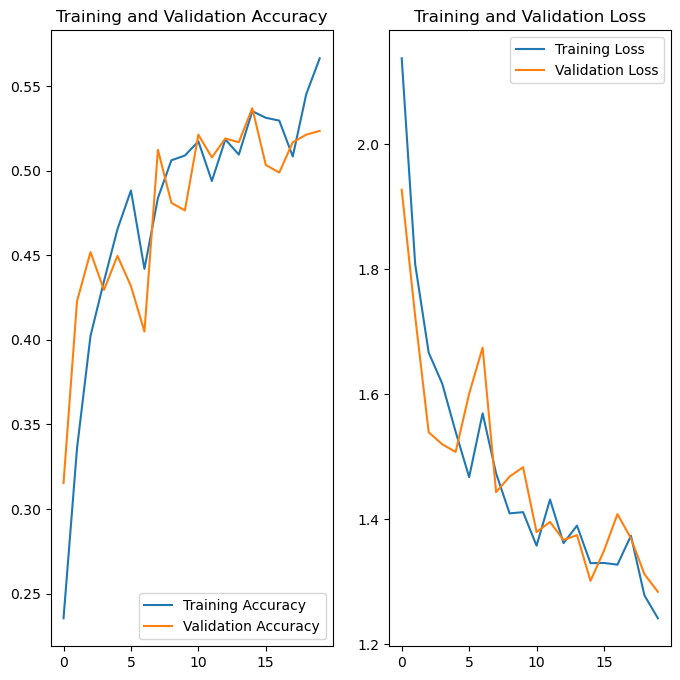

In [133]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings: 

1. Data augmentation has improved the model's generalization by reducing overfitting.
2. The training and validation accuracy show an upward trend with a smaller gap than before, indicating better performance. 
3. Training loss has decreased significantly, and validation loss is now closer to training loss with fewer fluctuations, making the model more stable.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

2025-02-19 23:29:18.404166: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


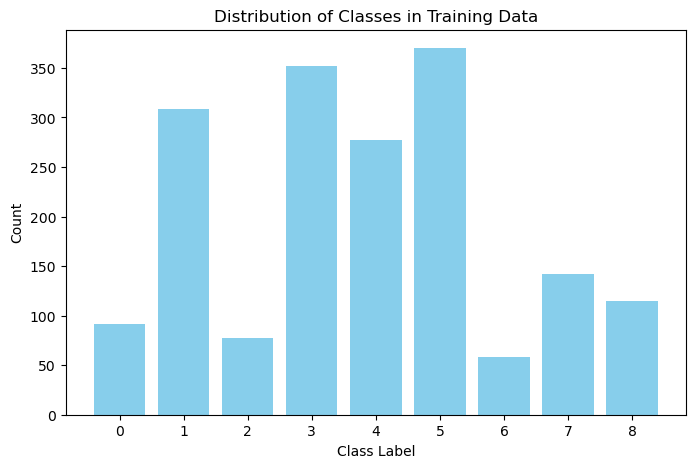

In [136]:
## Your code goes here.
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Extract class counts
class_counts = Counter()

for _, labels in train_ds:  # Iterate over batches
    class_counts.update(labels.numpy())  # Convert labels to NumPy and count occurrences

# Convert dictionary to sorted lists for plotting
class_labels, class_frequencies = zip(*sorted(class_counts.items()))

# Plot class distribution
plt.figure(figsize=(8, 5))
plt.bar(class_labels, class_frequencies, color='skyblue')
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Distribution of Classes in Training Data")
plt.xticks(class_labels)
plt.show()

#### Findings:
1. Class with the Least Number of Samples: Class 2 has the fewest samples, with a count of approximately 75.
2. Dominant Classes: Classes 3 and 5 are the most dominant, with counts exceeding 350 and approaching 400, respectively.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

### Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [141]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

print('Augmentor pipeline is complete')

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x30B757050>: 100%|█|


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x30B41C990>: 100%|█|


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x30B0E2B50>: 100%|█|


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x323FA8590>: 100%|█


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x30AF2BAD0>: 100%|█|


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x30B6C3050>: 100%|█|


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x30F566810>: 100%|█


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x30B3E0590>: 100%|█|


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x30B431750>: 100%|█|

Augmentor pipeline is complete


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [143]:
import glob
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [145]:
path_list = glob.glob(os.path.join(data_dir_train, "*", "output", "*.jpg"))
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000311.jpg_8efb6c07-212f-4a4e-8378-e269eaea1d2b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000174.jpg_ab266f16-1ef2-49b0-a3be-455df64b975f.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000395.jpg_381bf8c0-42b0-435e-8438-e02a65cdce7e.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000302.jpg_531dd31b-ad4a-482b-9788-cd76727f212e.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011043.jpg_ea3169ca-9a22-4959-be0b-4b6de44587e5.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009890.jpg_f63d5316-52c9-4e7b-b392-1b16f9e0cb54.jpg',
 'Skin cancer IS

In [146]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) 
                   for y in glob.glob(os.path.join(data_dir_train, "*", "output", "*.jpg"))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [147]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [148]:
# Debugging: Check if dataframe_dict_new has data
print(f"Dictionary length: {len(dataframe_dict_new)}")

# Convert dictionary to DataFrame
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])

# Verify df2
print(df2.head())

# Ensure original_df is defined
if 'original_df' not in globals():
    original_df = pd.DataFrame(columns=['Path', 'Label'])

# Check DataFrame structures
print(original_df.dtypes)
print(df2.dtypes)

# Concatenate DataFrames
new_df = pd.concat([original_df, df2], ignore_index=True)

# Verify result
print(new_df.head())
new_df['Label'].value_counts()

Dictionary length: 4500
                                                Path     Label
0  Skin cancer ISIC The International Skin Imagin...  melanoma
1  Skin cancer ISIC The International Skin Imagin...  melanoma
2  Skin cancer ISIC The International Skin Imagin...  melanoma
3  Skin cancer ISIC The International Skin Imagin...  melanoma
4  Skin cancer ISIC The International Skin Imagin...  melanoma
Path     object
Label    object
dtype: object
Path     object
Label    object
dtype: object
                                                Path     Label
0  Skin cancer ISIC The International Skin Imagin...  melanoma
1  Skin cancer ISIC The International Skin Imagin...  melanoma
2  Skin cancer ISIC The International Skin Imagin...  melanoma
3  Skin cancer ISIC The International Skin Imagin...  melanoma
4  Skin cancer ISIC The International Skin Imagin...  melanoma


Label
melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [151]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [153]:
# Define dataset directories
original_data_dir = "Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma"
augmented_data_dir = "Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output"

# Combine both paths into a single directory (if needed, move augmented data)
data_dir_train = original_data_dir  # Ensure all augmented images are inside the original directory

print("Training Data Directory:", data_dir_train)

# Load training dataset correctly
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,    # Use the base directory that contains all images
    seed=123,
    validation_split=0.2,  # 20% for validation
    subset="training",  # ✅ Choose 'training' to load only training data
    image_size=(img_height, img_width),
    batch_size=batch_size
)

print("Training dataset successfully loaded!")

Training Data Directory: Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma
Found 500 files belonging to 1 classes.
Using 400 files for training.
Training dataset successfully loaded!


#### **Todo:** Create a validation dataset

In [155]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,  # 20% of data for validation
    subset="validation",  # ✅ Correct parameter for validation data
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 500 files belonging to 1 classes.
Using 100 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [157]:
## your code goes here
from tensorflow.keras import layers, models

model = models.Sequential([
    # Data normalization layer
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Normalize pixel values

    # Data augmentation (optional, can be moved outside model)
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),

    # Convolutional layers
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    # Flattening
    layers.Flatten(),
    
    # Fully connected layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Regularization

    # Output layer (adjust number of classes)
    layers.Dense(len(class_names), activation='softmax')
])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [159]:
## your code goes here

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("Model compiled successfully!")

Model compiled successfully!


#### **Todo:**  Train your model

In [161]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks to optimize training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,  # Using 50 epochs
    callbacks=[early_stopping, lr_scheduler]  # Early stopping & LR schedule
)
print("Model training completed!")

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step - accuracy: 0.8616 - loss: 0.4949 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 299ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 301ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 290

In [ ]:
model.save("melanoma_cnn_model.h5")

#### **Todo:**  Visualize the model results

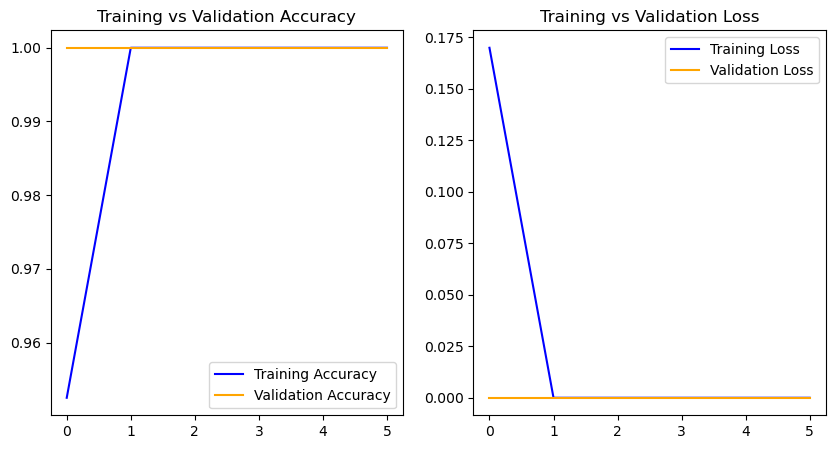

In [163]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Set correct epoch range
epochs_range = range(len(acc))  

plt.figure(figsize=(10, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

#### Findings
1. Overfitting is still present or possible data leakage. Loss values near zero indicate overconfidence, likely due to overfitting.
2. Class rebalance may have introduced issues.